
# Masksembles on MNIST — Tutorial

Welcome! 👋

This notebook walks you through using **Masksembles** for uncertainty‑aware inference on the classic **MNIST** dataset.  

You'll see how to:

- Load and preprocess MNIST
- Define **Masksembles** layers (`Masksembles2D` / `Masksembles1D`)
- Build a small CNN
- Train and validate in PyTorch
- Run **per‑submodel predictions** (ensembled behavior) at inference time
- Avoid common pitfalls

> **What is Masksembles?**  
> Masksembles builds multiple *subnetworks* inside a single model using deterministic, non‑overlapping masks. At inference time you can obtain diverse predictions (like an ensemble) **without** keeping multiple separate models. This gives you better **uncertainty estimation** and often more robust predictions with minimal overhead.



## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Load MNIST & Preprocessing](#load-preprocess)
3. [Masksembles Layers](#masksembles-layers)
4. [Model Architecture](#model-architecture)
5. [Training Setup](#training-setup)
6. [Training Loop](#training-loop)
7. [Evaluation & Inference](#eval-infer)
8. [Next Steps](#next-steps)


But before we start, lets make sure you installed Masksembles package.

In [1]:
!pip install masksembles
!wget https://github.com/nikitadurasov/masksembles/raw/main/images/complex_sample_mnist.npy

--2025-11-09 12:52:18--  https://github.com/nikitadurasov/masksembles/raw/main/images/complex_sample_mnist.npy
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nikitadurasov/masksembles/main/images/complex_sample_mnist.npy [following]
--2025-11-09 12:52:18--  https://raw.githubusercontent.com/nikitadurasov/masksembles/main/images/complex_sample_mnist.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6400 (6.2K) [application/octet-stream]
Saving to: ‘complex_sample_mnist.npy’

complex_sample_mnis 100%[===================>]   6.25K  --.-KB/s    in 0s      

2025-11-09 12:52:18 (96.2 MB/s) - ‘comp


## 1. Setup & Imports <a id="setup-imports"></a>

This section imports PyTorch, TorchVision, and the other packages used later.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms


## 2. Load MNIST & Preprocessing <a id="load-preprocess"></a>

Here we load MNIST and transform images to **tensors in [0, 1]**.  
Remember that **PyTorch uses channel‑first** tensors *(N, C, H, W)*, so MNIST images should become shape `(N, 1, 28, 28)`.


In [3]:
# Model / data parameters
num_classes = 10
input_shape = (1, 28, 28)  # PyTorch uses channel-first format (C, H, W)

# Define transform: convert to tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
images, labels = next(iter(train_loader))
print("x_train shape:", images.shape)  # [batch_size, 1, 28, 28]
print(len(train_dataset), "train samples")
print(len(test_dataset), "test samples")

# Convert labels to one-hot if needed
# (usually not needed for CrossEntropyLoss)
y_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
print("y_train one-hot shape:", y_one_hot.shape)


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.13MB/s]

x_train shape: torch.Size([64, 1, 28, 28])
60000 train samples
10000 test samples
y_train one-hot shape: torch.Size([64, 10])



## 3. Masksembles Layers <a id="masksembles-layers"></a>

These classes (`Masksembles2D`, `Masksembles1D`) create **non‑overlapping channel masks** that define *submodels* within the same network.  
- `Masksembles2D`: apply masks on convolutional feature maps (C×H×W).  
- `Masksembles1D`: apply masks on flattened features (C).  
Key arguments:
- `channels`: number of channels in the input.
- `n`: number of submodels (masks).
- `scale`: controls correlation/capacity trade‑off between submodels.


In [4]:
from masksembles.torch import Masksembles2D, Masksembles1D

In order to transform regular model into Masksembles model one should add Masksembles2D or Masksembles1D layers in it. General recommendation is to insert these layers right before or after convolutional layers.

In example below we'll use both Masksembles2D and Masksembles1D layers applied after convolutions.


## 4. Model Architecture <a id="model-architecture"></a>

We define a small CNN with ELU activations and interleave **Masksembles** after conv and before the final linear layer.  
After two conv+pool blocks, MNIST's 28×28 maps down to 5×5; the final linear projects to 10 classes.


In [8]:
import torch
from torch import nn

from masksembles import common


class Masksembles2D(nn.Module):
    """
    :class:`Masksembles2D` is high-level class that implements Masksembles approach
    for 2-dimensional inputs (similar to :class:`torch.nn.Dropout2d`).

    :param channels: int, number of channels used in masks.
    :param n: int, number of masks
    :param scale: float, scale parameter similar to *S* in [1]. Larger values decrease \
        subnetworks correlations but at the same time decrease capacity of every individual model.

    Shape:
        * Input: (N, C, H, W)
        * Output: (N, C, H, W) (same shape as input)

    Examples:

    >>> m = Masksembles2D(16, 4, 2.0)
    >>> input = torch.ones([4, 16, 28, 28])
    >>> output = m(input)

    References:

    [1] `Masksembles for Uncertainty Estimation`,
    Nikita Durasov, Timur Bagautdinov, Pierre Baque, Pascal Fua

    """
    def __init__(self, channels: int, n: int, scale: float):
        super().__init__()
        self.channels, self.n, self.scale = channels, n, scale
        masks_np = common.generation_wrapper(channels, n, scale)  # numpy float64 by default
        masks = torch.as_tensor(masks_np, dtype=torch.float32)    # make float32 here
        self.register_buffer('masks', masks, persistent=False)    # not trainable, moves with .to()

    def forward(self, inputs):
        # make sure masks match dtype/device (usually already true because of buffer, but safe)
        masks = self.masks.to(dtype=inputs.dtype, device=inputs.device)

        batch = inputs.shape[0]
        # safer split even if batch % n != 0
        chunks = torch.chunk(inputs.unsqueeze(1), self.n, dim=0)  # returns nearly equal chunks
        x = torch.cat(chunks, dim=1).permute(1, 0, 2, 3, 4)       # [n, ?, C, H, W]
        x = x * masks.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)    # broadcast masks
        x = torch.cat(torch.split(x, 1, dim=0), dim=1)
        return x.squeeze(0)



class Masksembles1D(nn.Module):
    """
    :class:`Masksembles1D` is high-level class that implements Masksembles approach
    for 1-dimensional inputs (similar to :class:`torch.nn.Dropout`).

    :param channels: int, number of channels used in masks.
    :param n: int, number of masks
    :param scale: float, scale parameter similar to *S* in [1]. Larger values decrease \
        subnetworks correlations but at the same time decrease capacity of every individual model.

    Shape:
        * Input: (N, C)
        * Output: (N, C) (same shape as input)

    Examples:

    >>> m = Masksembles1D(16, 4, 2.0)
    >>> input = torch.ones([4, 16])
    >>> output = m(input)


    References:

    [1] `Masksembles for Uncertainty Estimation`,
    Nikita Durasov, Timur Bagautdinov, Pierre Baque, Pascal Fua

    """

    def __init__(self, channels: int, n: int, scale: float):
        super().__init__()
        self.channels, self.n, self.scale = channels, n, scale
        masks_np = common.generation_wrapper(channels, n, scale)
        masks = torch.as_tensor(masks_np, dtype=torch.float32)
        self.register_buffer('masks', masks, persistent=False)

    def forward(self, inputs):
        masks = self.masks.to(dtype=inputs.dtype, device=inputs.device)

        batch = inputs.shape[0]
        chunks = torch.chunk(inputs.unsqueeze(1), self.n, dim=0)
        x = torch.cat(chunks, dim=1).permute(1, 0, 2)             # [n, ?, C]
        x = x * masks.unsqueeze(1)
        x = torch.cat(torch.split(x, 1, dim=0), dim=1)
        return x.squeeze(0)


In [9]:
class MasksemblesCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.mask1 = Masksembles2D(32, n=4, scale=2.0)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.mask2 = Masksembles2D(64, n=4, scale=2.0)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.mask3 = Masksembles1D(64 * 5 * 5, n=4, scale=2.0)
        self.fc = nn.Linear(64 * 5 * 5, num_classes)  # 5×5 after two 2×2 pools from 28×28 input

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.mask1(x)
        x = self.pool1(x)

        x = F.elu(self.conv2(x))
        x = self.mask2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.mask3(x)
        x = F.softmax(self.fc(x), dim=1)
        return x


# Instantiate and summarize
model = MasksemblesCNN(num_classes=10)
print(model)

# Print parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MasksemblesCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mask1): Masksembles2D()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mask2): Masksembles2D()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mask3): Masksembles1D()
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)

Total parameters: 34,826
Trainable parameters: 34,826


Training of Masksembles is not different from training of regular model. So we just use standard Pytorch training loop.


## 5. Training Setup <a id="training-setup"></a>

We configure:
- **Loss**: `CrossEntropyLoss` (expects integer class indices, not one‑hot)
- **Optimizer**: `Adam`
- **DataLoaders**: mini‑batches for train and validation (90/10 split)


In [10]:
# Model, loss, optimizer
model = MasksemblesCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MasksemblesCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mask1): Masksembles2D()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mask2): Masksembles2D()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mask3): Masksembles1D()
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


## 6. Training Loop <a id="training-loop"></a>

Standard PyTorch loop:
1. `model.train()`, forward pass
2. Compute loss, `backward()`, `step()`
3. Track accuracy
Then switch to `model.eval()` for validation with `torch.no_grad()`.


In [11]:
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        train_correct += (outputs.argmax(1) == y_batch).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * x_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    # Print epoch stats
    print(
        f"Epoch {epoch+1}/{epochs} "
        f"- Train loss: {train_loss/len(train_loader.dataset):.4f}, "
        f"Train acc: {train_correct/len(train_loader.dataset):.4f}, "
        f"Val loss: {val_loss/len(test_loader.dataset):.4f}, "
        f"Val acc: {val_correct/len(test_loader.dataset):.4f}"
    )


Epoch 1/3 - Train loss: 1.5990, Train acc: 0.8808, Val loss: 1.5153, Val acc: 0.9487
Epoch 2/3 - Train loss: 1.5098, Train acc: 0.9545, Val loss: 1.4981, Val acc: 0.9648
Epoch 3/3 - Train loss: 1.4985, Train acc: 0.9646, Val loss: 1.4927, Val acc: 0.9695



## 7. Evaluation & Inference <a id="eval-infer"></a>

For evaluation, we disable gradients (`torch.no_grad()`) and call `model.eval()` to turn off training‑time behavior.  
We then compute `argmax` over class logits to get predicted labels.

### **Important Notes on Inference <a id="important"></a>:** Batch tiling and mask assignment

Masksembles layers divide each batch into *N* segments — one for each submodel (mask).  
That means:
- The **first** 1/N of the batch goes through the first mask,  
- The **second** 1/N through the second mask, and so on.

So, to obtain predictions from **all submodels**, you need to **tile the same input image** *N* times along the batch dimension.  
Each of these replicated samples will be processed by a different submodel.  
After inference, you can then collect the *N* outputs to see how each submodel predicts the same input.



Now, we will check that all of Masksembles' submodels would predict similar predictions for training samples.

In [12]:
img = train_dataset[0][0] # just random image from training set

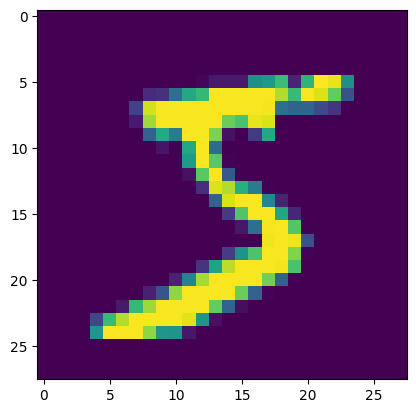

In [13]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

To acquire predictions from different submodels one should transform input (with shape [1, H, W, C]) into batch (with shape [M, H, W, C]) that consists of M copies of original input (H - height of image, W - width of image, C - number of channels).

As we can see Masksembles submodels produce similar predictions for training set samples.

In [18]:
# Suppose img has shape (28, 28, 1)
inputs = torch.tile(img[None], (4, 1, 1, 1))       # (4, 1, 28, 28)

# Send to same device as model
device = next(model.parameters()).device
inputs_t = inputs.to(device)

# Inference
model.eval()
with torch.no_grad():
    predictions = model(inputs_t)  # (4, num_classes)
    predicted_classes = predictions.argmax(dim=1)

# Print predictions
for i, cls in enumerate(predicted_classes):
    print(f"PREDICTION OF {i+1} MODEL: {cls.item()} CLASS")


PREDICTION OF 1 MODEL: 3 CLASS
PREDICTION OF 2 MODEL: 5 CLASS
PREDICTION OF 3 MODEL: 5 CLASS
PREDICTION OF 4 MODEL: 5 CLASS


On out-of-distribution samples Masksembles should produce predictions with high variance, let's check it on complex samples from MNIST.

In [19]:
img = np.array(np.load("./complex_sample_mnist.npy")[::-1, ::-1])
img = torch.tensor(img).permute(2, 0, 1).float()

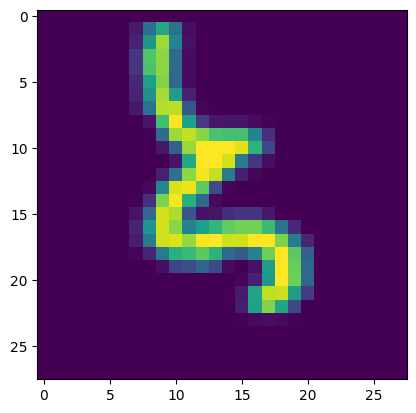

In [20]:
plt.imshow(img.permute(1, 2, 0))

In [21]:
# Suppose img has shape (28, 28, 1)
# Duplicate it 4 times
inputs = torch.tile(img[None], (4, 1, 1, 1))   # (4, 28, 28, 1)

# Move to same device as model
device = next(model.parameters()).device
inputs_t = inputs.to(device)

# Run the model
model.eval()
with torch.no_grad():
    predictions = model(inputs_t)            # shape: (4, num_classes)
    predicted_classes = predictions.argmax(dim=1)  # argmax over class dimension

# Print results like in TensorFlow
for i, cls in enumerate(predicted_classes):
    print(f"PREDICTION OF {i+1} MODEL: {cls.item()} CLASS")


PREDICTION OF 1 MODEL: 3 CLASS
PREDICTION OF 2 MODEL: 5 CLASS
PREDICTION OF 3 MODEL: 5 CLASS
PREDICTION OF 4 MODEL: 5 CLASS



## 8. Next Steps <a id="next-steps"></a>

- Try different `n` and `scale` to explore accuracy vs. diversity.  
- Aggregate submodel logits (mean/median) for stronger predictions.  
- Visualize per‑submodel confidence for **uncertainty estimation**.  
- Swap MNIST for CIFAR‑10 or your own dataset to test generalization.
